# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.385823617966607 -2.7609070097386095
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [15]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [16]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                    labels=reward*tf.ones_like(Qs_logits)))
    g_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
                                                                     labels=tf.reshape(tf.nn.sigmoid(targetQs[1:]), 
                                                                         shape=[-1, 1])))
    #g_lossP = tf.reduce_mean(neg_log_prob_actions * tf.nn.sigmoid(targetQs))
    #g_lossP = tf.reduce_mean(neg_log_prob_actions * targetQs)
    g_lossP = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    #g_loss = g_lossQ + g_lossP
    g_loss = g_lossP
    d_loss += g_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, g_lossQ, g_lossP

In [17]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [18]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.g_lossP = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [19]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [20]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [21]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [23]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_lossQ, g_lossP, g_loss, d_loss, _, _ = sess.run([model.g_lossQ, model.g_lossP, 
                                                           model.g_loss, model.d_loss, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'glossQ:{:.4f}'.format(g_lossQ),
              'glossP:{:.4f}'.format(g_lossP),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:10.0000 glossQ:0.6848 glossP:-0.1262 gloss:-0.1262 dloss:1.2862
Episode:1 meanR:9.5000 glossQ:0.6927 glossP:0.0347 gloss:0.0347 dloss:1.4077
Episode:2 meanR:9.3333 glossQ:0.6931 glossP:0.0037 gloss:0.0037 dloss:1.3871
Episode:3 meanR:9.5000 glossQ:0.6928 glossP:-0.0335 gloss:-0.0335 dloss:1.3599
Episode:4 meanR:9.6000 glossQ:0.6914 glossP:-0.0689 gloss:-0.0689 dloss:1.3339
Episode:5 meanR:9.8333 glossQ:0.6883 glossP:-0.1164 gloss:-0.1164 dloss:1.3001
Episode:6 meanR:9.5714 glossQ:0.6862 glossP:-0.1500 gloss:-0.1500 dloss:1.2828
Episode:7 meanR:12.5000 glossQ:0.6726 glossP:-0.2568 gloss:-0.2568 dloss:1.2278
Episode:8 meanR:16.7778 glossQ:0.6825 glossP:-0.1940 gloss:-0.1940 dloss:1.2749
Episode:9 meanR:22.0000 glossQ:0.6834 glossP:-0.1875 gloss:-0.1875 dloss:1.2878
Episode:10 meanR:27.4545 glossQ:0.6801 glossP:-0.2103 gloss:-0.2103 dloss:1.2836
Episode:11 meanR:32.4167 glossQ:0.6794 glossP:-0.2196 gloss:-0.2196 dloss:1.2820
Episode:12 meanR:36.4615 glossQ:0.6773 glossP:-0

Episode:102 meanR:46.1900 glossQ:0.3000 glossP:-1.6543 gloss:-1.6543 dloss:0.5436
Episode:103 meanR:46.5200 glossQ:0.3213 glossP:-1.5693 gloss:-1.5693 dloss:0.6263
Episode:104 meanR:47.1300 glossQ:0.3460 glossP:-1.4537 gloss:-1.4537 dloss:0.7642
Episode:105 meanR:48.0800 glossQ:0.3406 glossP:-1.4815 gloss:-1.4815 dloss:0.9149
Episode:106 meanR:48.3700 glossQ:0.3794 glossP:-1.3238 gloss:-1.3238 dloss:0.6577
Episode:107 meanR:48.3000 glossQ:0.3798 glossP:-1.3248 gloss:-1.3248 dloss:0.6158
Episode:108 meanR:48.0600 glossQ:0.3790 glossP:-1.3265 gloss:-1.3265 dloss:0.6186
Episode:109 meanR:47.6200 glossQ:0.3749 glossP:-1.3412 gloss:-1.3412 dloss:0.6055
Episode:110 meanR:47.0000 glossQ:0.3724 glossP:-1.3511 gloss:-1.3511 dloss:0.5826
Episode:111 meanR:46.3500 glossQ:0.3585 glossP:-1.3948 gloss:-1.3948 dloss:0.5719
Episode:112 meanR:45.7000 glossQ:0.3476 glossP:-1.4327 gloss:-1.4327 dloss:0.5493
Episode:113 meanR:44.1100 glossQ:0.3287 glossP:-1.4982 gloss:-1.4982 dloss:0.4993
Episode:114 mean

Episode:206 meanR:38.2300 glossQ:0.3308 glossP:-1.4865 gloss:-1.4865 dloss:0.5480
Episode:207 meanR:38.1900 glossQ:0.3243 glossP:-1.5117 gloss:-1.5117 dloss:0.5268
Episode:208 meanR:38.1300 glossQ:0.3168 glossP:-1.5372 gloss:-1.5372 dloss:0.5129
Episode:209 meanR:38.0300 glossQ:0.2941 glossP:-1.6239 gloss:-1.6239 dloss:0.4572
Episode:210 meanR:37.9800 glossQ:0.2813 glossP:-1.6714 gloss:-1.6714 dloss:0.4406
Episode:211 meanR:37.8800 glossQ:0.2579 glossP:-1.7633 gloss:-1.7633 dloss:0.3972
Episode:212 meanR:37.8400 glossQ:0.2575 glossP:-1.7662 gloss:-1.7662 dloss:0.4161
Episode:213 meanR:37.8500 glossQ:0.2303 glossP:-1.8852 gloss:-1.8852 dloss:0.3790
Episode:214 meanR:37.8300 glossQ:0.2214 glossP:-1.9310 gloss:-1.9310 dloss:0.3426
Episode:215 meanR:37.8100 glossQ:0.2058 glossP:-2.0091 gloss:-2.0091 dloss:0.3287
Episode:216 meanR:37.8000 glossQ:0.2131 glossP:-1.9750 gloss:-1.9750 dloss:0.3421
Episode:217 meanR:37.7900 glossQ:0.2020 glossP:-2.0378 gloss:-2.0378 dloss:0.3186
Episode:218 mean

Episode:311 meanR:33.9800 glossQ:0.2677 glossP:-1.7367 gloss:-1.7367 dloss:0.4618
Episode:312 meanR:34.1200 glossQ:0.2692 glossP:-1.7281 gloss:-1.7281 dloss:0.4985
Episode:313 meanR:34.2500 glossQ:0.2627 glossP:-1.7558 gloss:-1.7558 dloss:0.4813
Episode:314 meanR:34.4300 glossQ:0.2587 glossP:-1.7730 gloss:-1.7730 dloss:0.4770
Episode:315 meanR:34.6000 glossQ:0.2575 glossP:-1.7776 gloss:-1.7776 dloss:0.4756
Episode:316 meanR:34.7800 glossQ:0.2530 glossP:-1.7959 gloss:-1.7959 dloss:0.4812
Episode:317 meanR:34.8900 glossQ:0.2383 glossP:-1.8630 gloss:-1.8630 dloss:0.4177
Episode:318 meanR:34.9400 glossQ:0.2214 glossP:-1.9451 gloss:-1.9451 dloss:0.3659
Episode:319 meanR:35.0700 glossQ:0.2319 glossP:-1.8925 gloss:-1.8925 dloss:0.4436
Episode:320 meanR:34.8400 glossQ:0.1886 glossP:-2.1077 gloss:-2.1077 dloss:0.3169
Episode:321 meanR:32.4300 glossQ:0.1729 glossP:-2.2005 gloss:-2.2005 dloss:0.3120
Episode:322 meanR:31.5700 glossQ:0.1831 glossP:-2.1335 gloss:-2.1335 dloss:0.3225
Episode:323 mean

Episode:411 meanR:37.7400 glossQ:0.2655 glossP:-1.7848 gloss:-1.7848 dloss:0.5473
Episode:412 meanR:38.3500 glossQ:0.3345 glossP:-1.4999 gloss:-1.4999 dloss:0.8396
Episode:413 meanR:38.6100 glossQ:0.3373 glossP:-1.4927 gloss:-1.4927 dloss:0.6826
Episode:414 meanR:38.7400 glossQ:0.3444 glossP:-1.4665 gloss:-1.4665 dloss:0.6340
Episode:415 meanR:39.1200 glossQ:0.3409 glossP:-1.4777 gloss:-1.4777 dloss:0.7367
Episode:416 meanR:38.9700 glossQ:0.1987 glossP:-2.1352 gloss:-2.1352 dloss:0.3472
Episode:417 meanR:39.0700 glossQ:0.2593 glossP:-1.8132 gloss:-1.8132 dloss:0.4996
Episode:418 meanR:39.9900 glossQ:0.3190 glossP:-1.5624 gloss:-1.5624 dloss:0.9063
Episode:419 meanR:40.0600 glossQ:0.3349 glossP:-1.4919 gloss:-1.4919 dloss:0.5924
Episode:420 meanR:40.2100 glossQ:0.3307 glossP:-1.5104 gloss:-1.5104 dloss:0.5620
Episode:421 meanR:40.2800 glossQ:0.3271 glossP:-1.5243 gloss:-1.5243 dloss:0.5316
Episode:422 meanR:40.3300 glossQ:0.3159 glossP:-1.5631 gloss:-1.5631 dloss:0.5082
Episode:423 mean

Episode:513 meanR:35.9800 glossQ:0.2363 glossP:-1.8680 gloss:-1.8680 dloss:0.6690
Episode:514 meanR:38.3200 glossQ:0.2387 glossP:-1.8563 gloss:-1.8563 dloss:1.7799
Episode:515 meanR:38.5400 glossQ:0.2511 glossP:-1.8047 gloss:-1.8047 dloss:0.7816
Episode:516 meanR:39.4000 glossQ:0.2093 glossP:-2.0230 gloss:-2.0230 dloss:0.8561
Episode:517 meanR:39.9000 glossQ:0.2033 glossP:-2.0564 gloss:-2.0564 dloss:0.7391
Episode:518 meanR:39.7000 glossQ:0.2277 glossP:-1.9196 gloss:-1.9196 dloss:0.7731
Episode:519 meanR:40.1000 glossQ:0.2349 glossP:-1.8877 gloss:-1.8877 dloss:0.7042
Episode:520 meanR:40.0700 glossQ:0.2608 glossP:-1.7767 gloss:-1.7767 dloss:0.4644
Episode:521 meanR:40.0700 glossQ:0.2748 glossP:-1.7209 gloss:-1.7209 dloss:0.4655
Episode:522 meanR:40.0700 glossQ:0.2648 glossP:-1.7620 gloss:-1.7620 dloss:0.4441
Episode:523 meanR:40.1100 glossQ:0.2820 glossP:-1.6942 gloss:-1.6942 dloss:0.4938
Episode:524 meanR:40.2000 glossQ:0.2727 glossP:-1.7325 gloss:-1.7325 dloss:0.4791
Episode:525 mean

Episode:619 meanR:46.2700 glossQ:0.2486 glossP:-1.8201 gloss:-1.8201 dloss:0.6922
Episode:620 meanR:46.9400 glossQ:0.2402 glossP:-1.8565 gloss:-1.8565 dloss:0.8005
Episode:621 meanR:47.2200 glossQ:0.2315 glossP:-1.9046 gloss:-1.9046 dloss:0.5703
Episode:622 meanR:48.0700 glossQ:0.2351 glossP:-1.8803 gloss:-1.8803 dloss:0.8703
Episode:623 meanR:48.2900 glossQ:0.2268 glossP:-1.9215 gloss:-1.9215 dloss:0.5549
Episode:624 meanR:48.3400 glossQ:0.2210 glossP:-1.9550 gloss:-1.9550 dloss:0.4502
Episode:625 meanR:48.5300 glossQ:0.2189 glossP:-1.9616 gloss:-1.9616 dloss:0.5213
Episode:626 meanR:48.6500 glossQ:0.2125 glossP:-1.9941 gloss:-1.9941 dloss:0.4247
Episode:627 meanR:48.8800 glossQ:0.2191 glossP:-1.9611 gloss:-1.9611 dloss:0.4820
Episode:628 meanR:49.0300 glossQ:0.2135 glossP:-1.9913 gloss:-1.9913 dloss:0.4318
Episode:629 meanR:49.1300 glossQ:0.2066 glossP:-2.0266 gloss:-2.0266 dloss:0.3959
Episode:630 meanR:49.1600 glossQ:0.2072 glossP:-2.0267 gloss:-2.0267 dloss:0.4085
Episode:631 mean

Episode:720 meanR:47.4800 glossQ:0.2542 glossP:-1.8052 gloss:-1.8052 dloss:0.4420
Episode:721 meanR:47.4800 glossQ:0.2389 glossP:-1.9344 gloss:-1.9344 dloss:0.5871
Episode:722 meanR:46.9400 glossQ:0.2364 glossP:-1.9454 gloss:-1.9454 dloss:0.5903
Episode:723 meanR:46.5600 glossQ:0.1065 glossP:-2.8474 gloss:-2.8474 dloss:0.2162
Episode:724 meanR:46.5400 glossQ:0.2437 glossP:-1.8550 gloss:-1.8550 dloss:0.4627
Episode:725 meanR:46.3800 glossQ:0.2630 glossP:-1.7705 gloss:-1.7705 dloss:0.4780
Episode:726 meanR:46.3200 glossQ:0.2254 glossP:-1.9510 gloss:-1.9510 dloss:0.4063
Episode:727 meanR:46.1100 glossQ:0.2002 glossP:-2.0791 gloss:-2.0791 dloss:0.3437
Episode:728 meanR:45.9300 glossQ:0.1504 glossP:-2.3607 gloss:-2.3607 dloss:0.2569
Episode:729 meanR:46.3800 glossQ:0.2540 glossP:-1.7971 gloss:-1.7971 dloss:0.6796
Episode:730 meanR:47.7200 glossQ:0.2067 glossP:-2.0050 gloss:-2.0050 dloss:1.1817
Episode:731 meanR:49.4600 glossQ:0.2136 glossP:-1.9810 gloss:-1.9810 dloss:1.4951
Episode:732 mean

Episode:822 meanR:92.6900 glossQ:0.6601 glossP:-0.3173 gloss:-0.3173 dloss:1.2840
Episode:823 meanR:93.7600 glossQ:0.6573 glossP:-0.3300 gloss:-0.3300 dloss:1.2638
Episode:824 meanR:94.0800 glossQ:0.6391 glossP:-0.4636 gloss:-0.4636 dloss:1.1393
Episode:825 meanR:94.4300 glossQ:0.6441 glossP:-0.4244 gloss:-0.4244 dloss:1.1626
Episode:826 meanR:94.8400 glossQ:0.6390 glossP:-0.4625 gloss:-0.4625 dloss:1.1423
Episode:827 meanR:95.3500 glossQ:0.6371 glossP:-0.4619 gloss:-0.4619 dloss:1.1487
Episode:828 meanR:95.4200 glossQ:0.5608 glossP:-0.7772 gloss:-0.7772 dloss:0.8926
Episode:829 meanR:95.4200 glossQ:0.6104 glossP:-0.5829 gloss:-0.5829 dloss:1.0919
Episode:830 meanR:93.9800 glossQ:0.5203 glossP:-0.9087 gloss:-0.9087 dloss:0.8165
Episode:831 meanR:92.0300 glossQ:0.5380 glossP:-0.8554 gloss:-0.8554 dloss:0.8512
Episode:832 meanR:90.9000 glossQ:0.5140 glossP:-0.9333 gloss:-0.9333 dloss:0.8026
Episode:833 meanR:90.5500 glossQ:0.5726 glossP:-0.7365 gloss:-0.7365 dloss:1.0471
Episode:834 mean

Episode:923 meanR:80.2000 glossQ:0.3305 glossP:-1.5414 gloss:-1.5414 dloss:0.5064
Episode:924 meanR:80.3300 glossQ:0.5089 glossP:-0.9433 gloss:-0.9433 dloss:0.9463
Episode:925 meanR:80.2600 glossQ:0.4768 glossP:-1.0540 gloss:-1.0540 dloss:0.8551
Episode:926 meanR:80.5600 glossQ:0.5270 glossP:-0.8865 gloss:-0.8865 dloss:1.0190
Episode:927 meanR:84.9000 glossQ:0.5293 glossP:-0.8768 gloss:-0.8768 dloss:2.0444
Episode:928 meanR:88.0800 glossQ:0.4912 glossP:-0.9959 gloss:-0.9959 dloss:1.6729
Episode:929 meanR:88.1200 glossQ:0.5108 glossP:-0.9344 gloss:-0.9344 dloss:0.9421
Episode:930 meanR:88.4200 glossQ:0.5563 glossP:-0.7875 gloss:-0.7875 dloss:0.9380
Episode:931 meanR:88.5200 glossQ:0.5442 glossP:-0.8289 gloss:-0.8289 dloss:0.8800
Episode:932 meanR:88.6600 glossQ:0.5468 glossP:-0.8214 gloss:-0.8214 dloss:0.8868
Episode:933 meanR:88.0500 glossQ:0.5235 glossP:-0.8966 gloss:-0.8966 dloss:0.8221
Episode:934 meanR:87.6300 glossQ:0.5279 glossP:-0.8826 gloss:-0.8826 dloss:0.8356
Episode:935 mean

Episode:1023 meanR:87.3100 glossQ:0.3936 glossP:-1.3740 gloss:-1.3740 dloss:0.7309
Episode:1024 meanR:86.8300 glossQ:0.4576 glossP:-1.1129 gloss:-1.1129 dloss:0.7251
Episode:1025 meanR:86.5400 glossQ:0.4536 glossP:-1.1244 gloss:-1.1244 dloss:0.7219
Episode:1026 meanR:85.8900 glossQ:0.4360 glossP:-1.1794 gloss:-1.1794 dloss:0.6992
Episode:1027 meanR:81.1000 glossQ:0.4160 glossP:-1.2414 gloss:-1.2414 dloss:0.6505
Episode:1028 meanR:77.9600 glossQ:0.4138 glossP:-1.2491 gloss:-1.2491 dloss:0.6472
Episode:1029 meanR:77.5000 glossQ:0.4125 glossP:-1.2547 gloss:-1.2547 dloss:0.6627
Episode:1030 meanR:77.3000 glossQ:0.4019 glossP:-1.2876 gloss:-1.2876 dloss:0.6444
Episode:1031 meanR:77.2700 glossQ:0.3939 glossP:-1.3146 gloss:-1.3146 dloss:0.6369
Episode:1032 meanR:77.2400 glossQ:0.3913 glossP:-1.3244 gloss:-1.3244 dloss:0.6370
Episode:1033 meanR:77.2400 glossQ:0.3666 glossP:-1.4071 gloss:-1.4071 dloss:0.5779
Episode:1034 meanR:77.1700 glossQ:0.3294 glossP:-1.5345 gloss:-1.5345 dloss:0.5085
Epis

Episode:1123 meanR:57.3400 glossQ:0.4030 glossP:-1.2853 gloss:-1.2853 dloss:1.1016
Episode:1124 meanR:58.3700 glossQ:0.3995 glossP:-1.2945 gloss:-1.2945 dloss:1.0246
Episode:1125 meanR:59.3500 glossQ:0.3879 glossP:-1.3480 gloss:-1.3480 dloss:1.0120
Episode:1126 meanR:60.0600 glossQ:0.3813 glossP:-1.3766 gloss:-1.3766 dloss:0.9081
Episode:1127 meanR:61.6400 glossQ:0.4448 glossP:-1.1496 gloss:-1.1496 dloss:1.2210
Episode:1128 meanR:62.1200 glossQ:0.3779 glossP:-1.3780 gloss:-1.3780 dloss:0.7864
Episode:1129 meanR:62.7300 glossQ:0.3955 glossP:-1.3180 gloss:-1.3180 dloss:0.8728
Episode:1130 meanR:63.2700 glossQ:0.3782 glossP:-1.3781 gloss:-1.3781 dloss:0.8283
Episode:1131 meanR:63.4000 glossQ:0.3536 glossP:-1.4845 gloss:-1.4845 dloss:0.6461
Episode:1132 meanR:63.5200 glossQ:0.3391 glossP:-1.5469 gloss:-1.5469 dloss:0.6319
Episode:1133 meanR:63.6900 glossQ:0.3351 glossP:-1.5621 gloss:-1.5621 dloss:0.6187
Episode:1134 meanR:63.6800 glossQ:0.2297 glossP:-1.9543 gloss:-1.9543 dloss:0.3787
Epis

Episode:1222 meanR:147.2000 glossQ:0.6306 glossP:-0.5184 gloss:-0.5184 dloss:1.1975
Episode:1223 meanR:147.8000 glossQ:0.6548 glossP:-0.3897 gloss:-0.3897 dloss:1.3446
Episode:1224 meanR:147.4500 glossQ:0.6169 glossP:-0.5680 gloss:-0.5680 dloss:1.1408
Episode:1225 meanR:147.0400 glossQ:0.6322 glossP:-0.4968 gloss:-0.4968 dloss:1.1564
Episode:1226 meanR:146.6000 glossQ:0.6105 glossP:-0.5853 gloss:-0.5853 dloss:1.0691
Episode:1227 meanR:144.9100 glossQ:0.4694 glossP:-1.0654 gloss:-1.0654 dloss:0.7357
Episode:1228 meanR:144.7100 glossQ:0.5914 glossP:-0.6472 gloss:-0.6472 dloss:1.0319
Episode:1229 meanR:145.7100 glossQ:0.6536 glossP:-0.4095 gloss:-0.4095 dloss:1.3194
Episode:1230 meanR:149.9200 glossQ:0.6479 glossP:-0.4436 gloss:-0.4436 dloss:1.7135
Episode:1231 meanR:154.5300 glossQ:0.6358 glossP:-0.4974 gloss:-0.4974 dloss:1.7530
Episode:1232 meanR:159.1400 glossQ:0.6334 glossP:-0.5038 gloss:-0.5038 dloss:1.7573
Episode:1233 meanR:161.5500 glossQ:0.6342 glossP:-0.4924 gloss:-0.4924 dloss

Episode:1321 meanR:145.6700 glossQ:0.5548 glossP:-0.7999 gloss:-0.7999 dloss:0.9354
Episode:1322 meanR:145.0300 glossQ:0.5711 glossP:-0.7462 gloss:-0.7462 dloss:0.9899
Episode:1323 meanR:143.3500 glossQ:0.5518 glossP:-0.8175 gloss:-0.8175 dloss:0.9228
Episode:1324 meanR:142.7700 glossQ:0.5531 glossP:-0.8140 gloss:-0.8140 dloss:0.9136
Episode:1325 meanR:142.2400 glossQ:0.5465 glossP:-0.8360 gloss:-0.8360 dloss:0.8910
Episode:1326 meanR:142.0700 glossQ:0.5588 glossP:-0.7938 gloss:-0.7938 dloss:0.9315
Episode:1327 meanR:142.3900 glossQ:0.5417 glossP:-0.8531 gloss:-0.8531 dloss:0.9121
Episode:1328 meanR:142.2100 glossQ:0.5317 glossP:-0.8852 gloss:-0.8852 dloss:0.8683
Episode:1329 meanR:140.7600 glossQ:0.5252 glossP:-0.9077 gloss:-0.9077 dloss:0.8851
Episode:1330 meanR:136.2400 glossQ:0.5373 glossP:-0.8666 gloss:-0.8666 dloss:0.9214
Episode:1331 meanR:131.8500 glossQ:0.5476 glossP:-0.8289 gloss:-0.8289 dloss:0.9705
Episode:1332 meanR:127.6200 glossQ:0.5522 glossP:-0.8092 gloss:-0.8092 dloss

Episode:1426 meanR:64.4000 glossQ:0.4048 glossP:-1.2951 gloss:-1.2951 dloss:0.7297
Episode:1427 meanR:64.1400 glossQ:0.3313 glossP:-1.5353 gloss:-1.5353 dloss:0.5208
Episode:1428 meanR:63.9800 glossQ:0.3118 glossP:-1.6249 gloss:-1.6249 dloss:0.4939
Episode:1429 meanR:63.6800 glossQ:0.2675 glossP:-1.8037 gloss:-1.8037 dloss:0.4265
Episode:1430 meanR:63.3200 glossQ:0.2619 glossP:-1.8418 gloss:-1.8418 dloss:0.4193
Episode:1431 meanR:62.8700 glossQ:0.3142 glossP:-1.6008 gloss:-1.6008 dloss:0.4983
Episode:1432 meanR:62.3000 glossQ:0.3274 glossP:-1.5543 gloss:-1.5543 dloss:0.5300
Episode:1433 meanR:61.4400 glossQ:0.3175 glossP:-1.5948 gloss:-1.5948 dloss:0.5012
Episode:1434 meanR:61.4000 glossQ:0.3835 glossP:-1.3867 gloss:-1.3867 dloss:0.6851
Episode:1435 meanR:61.0900 glossQ:0.4428 glossP:-1.1742 gloss:-1.1742 dloss:0.9521
Episode:1436 meanR:56.6100 glossQ:0.4090 glossP:-1.3067 gloss:-1.3067 dloss:0.7697
Episode:1437 meanR:55.9700 glossQ:0.2147 glossP:-2.0678 gloss:-2.0678 dloss:0.3568
Epis

Episode:1525 meanR:94.4700 glossQ:0.4560 glossP:-1.1394 gloss:-1.1394 dloss:0.7854
Episode:1526 meanR:99.0200 glossQ:0.5371 glossP:-0.8584 gloss:-0.8584 dloss:2.0318
Episode:1527 meanR:99.7100 glossQ:0.4534 glossP:-1.1418 gloss:-1.1418 dloss:0.9221
Episode:1528 meanR:100.0700 glossQ:0.4215 glossP:-1.2460 gloss:-1.2460 dloss:0.7707
Episode:1529 meanR:100.3500 glossQ:0.3939 glossP:-1.3392 gloss:-1.3392 dloss:0.6954
Episode:1530 meanR:100.6600 glossQ:0.4275 glossP:-1.2536 gloss:-1.2536 dloss:0.7540
Episode:1531 meanR:101.0200 glossQ:0.3977 glossP:-1.3310 gloss:-1.3310 dloss:0.7459
Episode:1532 meanR:101.1800 glossQ:0.3963 glossP:-1.3742 gloss:-1.3742 dloss:0.6903
Episode:1533 meanR:101.4500 glossQ:0.4052 glossP:-1.3557 gloss:-1.3557 dloss:0.7309
Episode:1534 meanR:102.0500 glossQ:0.4461 glossP:-1.1595 gloss:-1.1595 dloss:0.9601
Episode:1535 meanR:106.0800 glossQ:0.5150 glossP:-0.9228 gloss:-0.9228 dloss:2.0841
Episode:1536 meanR:106.7400 glossQ:0.4849 glossP:-1.0463 gloss:-1.0463 dloss:1.

Episode:1626 meanR:125.3800 glossQ:0.2752 glossP:-1.8134 gloss:-1.8134 dloss:0.4550
Episode:1627 meanR:124.6200 glossQ:0.2366 glossP:-2.0659 gloss:-2.0659 dloss:0.3892
Episode:1628 meanR:129.1100 glossQ:0.6041 glossP:-0.6358 gloss:-0.6358 dloss:1.8603
Episode:1629 meanR:131.1000 glossQ:0.6374 glossP:-0.4643 gloss:-0.4643 dloss:1.3822
Episode:1630 meanR:132.0800 glossQ:0.6175 glossP:-0.5460 gloss:-0.5460 dloss:1.2271
Episode:1631 meanR:131.6900 glossQ:0.3315 glossP:-1.5516 gloss:-1.5516 dloss:0.5200
Episode:1632 meanR:131.4300 glossQ:0.3537 glossP:-1.4697 gloss:-1.4697 dloss:0.5450
Episode:1633 meanR:131.1100 glossQ:0.2959 glossP:-1.7027 gloss:-1.7027 dloss:0.4703
Episode:1634 meanR:130.2200 glossQ:0.3394 glossP:-1.5262 gloss:-1.5262 dloss:0.5267
Episode:1635 meanR:125.3500 glossQ:0.3156 glossP:-1.6265 gloss:-1.6265 dloss:0.4989
Episode:1636 meanR:125.3400 glossQ:0.6159 glossP:-0.5349 gloss:-0.5349 dloss:1.1954
Episode:1637 meanR:126.4200 glossQ:0.6254 glossP:-0.4966 gloss:-0.4966 dloss

Episode:1724 meanR:244.5100 glossQ:0.6903 glossP:0.1048 gloss:0.1048 dloss:1.3911
Episode:1725 meanR:246.6200 glossQ:0.6888 glossP:0.1216 gloss:0.1216 dloss:1.3953
Episode:1726 meanR:249.1100 glossQ:0.6894 glossP:0.1185 gloss:0.1185 dloss:1.3827
Episode:1727 meanR:251.3400 glossQ:0.6885 glossP:0.1298 gloss:0.1298 dloss:1.3935
Episode:1728 meanR:248.2100 glossQ:0.6878 glossP:0.1406 gloss:0.1406 dloss:1.4125
Episode:1729 meanR:247.5900 glossQ:0.6861 glossP:0.1571 gloss:0.1571 dloss:1.4200
Episode:1730 meanR:248.2700 glossQ:0.6882 glossP:0.1350 gloss:0.1350 dloss:1.4027
Episode:1731 meanR:250.1800 glossQ:0.6887 glossP:0.1300 gloss:0.1300 dloss:1.4040
Episode:1732 meanR:251.9400 glossQ:0.6890 glossP:0.1263 gloss:0.1263 dloss:1.4101
Episode:1733 meanR:253.2400 glossQ:0.6886 glossP:0.1305 gloss:0.1305 dloss:1.4278
Episode:1734 meanR:255.1600 glossQ:0.6896 glossP:0.1135 gloss:0.1135 dloss:1.4024
Episode:1735 meanR:256.9000 glossQ:0.6902 glossP:0.1038 gloss:0.1038 dloss:1.4056
Episode:1736 mea

Episode:1824 meanR:322.6100 glossQ:0.5687 glossP:0.7092 gloss:0.7092 dloss:1.4597
Episode:1825 meanR:321.9900 glossQ:0.5881 glossP:0.6136 gloss:0.6136 dloss:1.5496
Episode:1826 meanR:320.9400 glossQ:0.6104 glossP:0.4882 gloss:0.4882 dloss:1.5250
Episode:1827 meanR:320.8900 glossQ:0.6162 glossP:0.4834 gloss:0.4834 dloss:1.4243
Episode:1828 meanR:320.0700 glossQ:0.6336 glossP:0.2135 gloss:0.2135 dloss:1.4843
Episode:1829 meanR:319.4700 glossQ:0.6392 glossP:0.2689 gloss:0.2689 dloss:1.4958
Episode:1830 meanR:318.1300 glossQ:0.6352 glossP:-0.0200 gloss:-0.0200 dloss:1.3899
Episode:1831 meanR:317.3200 glossQ:0.6361 glossP:0.1568 gloss:0.1568 dloss:1.4523
Episode:1832 meanR:316.8900 glossQ:0.6307 glossP:0.0914 gloss:0.0914 dloss:1.4259
Episode:1833 meanR:316.5100 glossQ:0.6149 glossP:-0.1046 gloss:-0.1046 dloss:1.3635
Episode:1834 meanR:315.3300 glossQ:0.6108 glossP:-0.2383 gloss:-0.2383 dloss:1.2975
Episode:1835 meanR:314.1200 glossQ:0.5843 glossP:-0.4643 gloss:-0.4643 dloss:1.1801
Episode:

Episode:1922 meanR:80.4200 glossQ:0.1923 glossP:-2.1218 gloss:-2.1218 dloss:0.3525
Episode:1923 meanR:78.8400 glossQ:0.1654 glossP:-2.2822 gloss:-2.2822 dloss:0.3185
Episode:1924 meanR:76.7800 glossQ:0.1537 glossP:-2.3696 gloss:-2.3696 dloss:0.2952
Episode:1925 meanR:75.2400 glossQ:0.1395 glossP:-2.5203 gloss:-2.5203 dloss:0.2528
Episode:1926 meanR:73.7800 glossQ:0.1547 glossP:-2.4159 gloss:-2.4159 dloss:0.2756
Episode:1927 meanR:71.6600 glossQ:0.1215 glossP:-2.5934 gloss:-2.5934 dloss:0.2615
Episode:1928 meanR:70.7300 glossQ:0.1400 glossP:-2.4845 gloss:-2.4845 dloss:0.2634
Episode:1929 meanR:69.7400 glossQ:0.1841 glossP:-2.1756 gloss:-2.1756 dloss:0.3442
Episode:1930 meanR:69.1500 glossQ:0.2053 glossP:-2.0897 gloss:-2.0897 dloss:0.3579
Episode:1931 meanR:68.1600 glossQ:0.2580 glossP:-1.8590 gloss:-1.8590 dloss:0.4624
Episode:1932 meanR:67.7200 glossQ:0.2450 glossP:-1.8490 gloss:-1.8490 dloss:0.8429
Episode:1933 meanR:68.7500 glossQ:0.2573 glossP:-1.7941 gloss:-1.7941 dloss:1.4002
Epis

Episode:2028 meanR:35.7700 glossQ:0.2630 glossP:-1.7970 gloss:-1.7970 dloss:0.4552
Episode:2029 meanR:35.8100 glossQ:0.2602 glossP:-1.8106 gloss:-1.8106 dloss:0.4518
Episode:2030 meanR:35.8300 glossQ:0.2395 glossP:-1.9011 gloss:-1.9011 dloss:0.4082
Episode:2031 meanR:35.8100 glossQ:0.2476 glossP:-1.8683 gloss:-1.8683 dloss:0.4381
Episode:2032 meanR:34.9600 glossQ:0.2324 glossP:-1.9372 gloss:-1.9372 dloss:0.3811
Episode:2033 meanR:33.2100 glossQ:0.3034 glossP:-1.6936 gloss:-1.6936 dloss:0.5593
Episode:2034 meanR:33.6100 glossQ:0.3394 glossP:-1.5219 gloss:-1.5219 dloss:0.7934
Episode:2035 meanR:33.2000 glossQ:0.2117 glossP:-2.1282 gloss:-2.1282 dloss:0.3431
Episode:2036 meanR:33.2600 glossQ:0.3000 glossP:-1.7047 gloss:-1.7047 dloss:0.5734
Episode:2037 meanR:33.1300 glossQ:0.1901 glossP:-2.1801 gloss:-2.1801 dloss:0.3228
Episode:2038 meanR:33.0900 glossQ:0.1722 glossP:-2.2639 gloss:-2.2639 dloss:0.3068
Episode:2039 meanR:33.2300 glossQ:0.2951 glossP:-1.7529 gloss:-1.7529 dloss:0.5784
Epis

Episode:2127 meanR:154.7300 glossQ:0.6823 glossP:-0.2000 gloss:-0.2000 dloss:1.5347
Episode:2128 meanR:159.5100 glossQ:0.6831 glossP:-0.1950 gloss:-0.1950 dloss:1.5305
Episode:2129 meanR:164.2900 glossQ:0.6894 glossP:-0.1160 gloss:-0.1160 dloss:1.4724
Episode:2130 meanR:169.1100 glossQ:0.6887 glossP:-0.1365 gloss:-0.1365 dloss:1.4873
Episode:2131 meanR:173.8900 glossQ:0.6826 glossP:-0.2051 gloss:-0.2051 dloss:1.5362
Episode:2132 meanR:178.7500 glossQ:0.6880 glossP:-0.1464 gloss:-0.1464 dloss:1.4934
Episode:2133 meanR:183.4400 glossQ:0.6927 glossP:-0.0485 gloss:-0.0485 dloss:1.4217
Episode:2134 meanR:184.1600 glossQ:0.6756 glossP:-0.2037 gloss:-0.2037 dloss:1.3307
Episode:2135 meanR:185.0600 glossQ:0.6819 glossP:-0.0953 gloss:-0.0953 dloss:1.3482
Episode:2136 meanR:185.3100 glossQ:0.6740 glossP:-0.1745 gloss:-0.1745 dloss:1.2961
Episode:2137 meanR:185.6300 glossQ:0.6611 glossP:-0.2306 gloss:-0.2306 dloss:1.2595
Episode:2138 meanR:186.5500 glossQ:0.6791 glossP:-0.0764 gloss:-0.0764 dloss

Episode:2225 meanR:167.2100 glossQ:0.6806 glossP:-0.1678 gloss:-0.1678 dloss:1.4482
Episode:2226 meanR:162.7300 glossQ:0.5076 glossP:-0.9433 gloss:-0.9433 dloss:0.9002
Episode:2227 meanR:158.0800 glossQ:0.4808 glossP:-1.0413 gloss:-1.0413 dloss:0.8126
Episode:2228 meanR:153.2800 glossQ:0.4596 glossP:-1.1088 gloss:-1.1088 dloss:0.7339
Episode:2229 meanR:148.4700 glossQ:0.4431 glossP:-1.1611 gloss:-1.1611 dloss:0.7087
Episode:2230 meanR:143.6100 glossQ:0.3927 glossP:-1.3293 gloss:-1.3293 dloss:0.6139
Episode:2231 meanR:138.7300 glossQ:0.3689 glossP:-1.4181 gloss:-1.4181 dloss:0.5781
Episode:2232 meanR:133.8300 glossQ:0.3078 glossP:-1.6641 gloss:-1.6641 dloss:0.4836
Episode:2233 meanR:129.0000 glossQ:0.3892 glossP:-1.3459 gloss:-1.3459 dloss:0.6182
Episode:2234 meanR:127.6700 glossQ:0.3611 glossP:-1.4440 gloss:-1.4440 dloss:0.5780
Episode:2235 meanR:126.8200 glossQ:0.3419 glossP:-1.5147 gloss:-1.5147 dloss:0.5427
Episode:2236 meanR:126.4200 glossQ:0.3632 glossP:-1.4500 gloss:-1.4500 dloss

Episode:2323 meanR:136.4600 glossQ:0.6842 glossP:-0.2202 gloss:-0.2202 dloss:1.5508
Episode:2324 meanR:138.0000 glossQ:0.6449 glossP:-0.3752 gloss:-0.3752 dloss:1.3973
Episode:2325 meanR:135.9600 glossQ:0.6501 glossP:-0.3888 gloss:-0.3888 dloss:1.2948
Episode:2326 meanR:137.0800 glossQ:0.6530 glossP:-0.3653 gloss:-0.3653 dloss:1.3010
Episode:2327 meanR:137.9900 glossQ:0.6445 glossP:-0.4132 gloss:-0.4132 dloss:1.2443
Episode:2328 meanR:138.8100 glossQ:0.6354 glossP:-0.4642 gloss:-0.4642 dloss:1.1958
Episode:2329 meanR:139.7000 glossQ:0.6393 glossP:-0.4486 gloss:-0.4486 dloss:1.2114
Episode:2330 meanR:140.3800 glossQ:0.6240 glossP:-0.5147 gloss:-0.5147 dloss:1.1461
Episode:2331 meanR:141.1300 glossQ:0.6300 glossP:-0.4940 gloss:-0.4940 dloss:1.1650
Episode:2332 meanR:141.9100 glossQ:0.6284 glossP:-0.4975 gloss:-0.4975 dloss:1.1656
Episode:2333 meanR:142.5800 glossQ:0.6137 glossP:-0.5538 gloss:-0.5538 dloss:1.1357
Episode:2334 meanR:143.2000 glossQ:0.6013 glossP:-0.6069 gloss:-0.6069 dloss

Episode:2422 meanR:260.6100 glossQ:0.6717 glossP:0.2902 gloss:0.2902 dloss:1.1772
Episode:2423 meanR:260.6100 glossQ:0.6811 glossP:0.2170 gloss:0.2170 dloss:1.2300
Episode:2424 meanR:263.2100 glossQ:0.6665 glossP:0.3218 gloss:0.3218 dloss:1.1545
Episode:2425 meanR:266.5700 glossQ:0.6837 glossP:0.1907 gloss:0.1907 dloss:1.2489
Episode:2426 meanR:269.9300 glossQ:0.6693 glossP:0.3052 gloss:0.3052 dloss:1.1663
Episode:2427 meanR:273.6700 glossQ:0.6636 glossP:0.3406 gloss:0.3406 dloss:1.1410
Episode:2428 meanR:277.0000 glossQ:0.6759 glossP:0.1810 gloss:0.1810 dloss:1.2899
Episode:2429 meanR:278.0400 glossQ:0.6752 glossP:0.0945 gloss:0.0945 dloss:1.3977
Episode:2430 meanR:279.8300 glossQ:0.6745 glossP:0.1434 gloss:0.1434 dloss:1.3825
Episode:2431 meanR:281.9700 glossQ:0.6731 glossP:0.1854 gloss:0.1854 dloss:1.3596
Episode:2432 meanR:283.5100 glossQ:0.6711 glossP:0.1612 gloss:0.1612 dloss:1.3909
Episode:2433 meanR:284.8700 glossQ:0.6701 glossP:0.1773 gloss:0.1773 dloss:1.4027
Episode:2434 mea

Episode:2525 meanR:276.2400 glossQ:0.6432 glossP:-0.0237 gloss:-0.0237 dloss:1.3839
Episode:2526 meanR:271.7000 glossQ:0.6267 glossP:-0.2802 gloss:-0.2802 dloss:1.2395
Episode:2527 meanR:267.0500 glossQ:0.6226 glossP:-0.4017 gloss:-0.4017 dloss:1.1591
Episode:2528 meanR:263.5000 glossQ:0.6424 glossP:-0.0574 gloss:-0.0574 dloss:1.3699
Episode:2529 meanR:261.9400 glossQ:0.6262 glossP:-0.2581 gloss:-0.2581 dloss:1.2610
Episode:2530 meanR:259.7800 glossQ:0.6065 glossP:-0.4320 gloss:-0.4320 dloss:1.1585
Episode:2531 meanR:257.1900 glossQ:0.5923 glossP:-0.5383 gloss:-0.5383 dloss:1.0953
Episode:2532 meanR:255.1700 glossQ:0.5637 glossP:-0.6955 gloss:-0.6955 dloss:1.0061
Episode:2533 meanR:254.0700 glossQ:0.6375 glossP:-0.1169 gloss:-0.1169 dloss:1.3572
Episode:2534 meanR:252.5600 glossQ:0.5845 glossP:-0.5824 gloss:-0.5824 dloss:1.0845
Episode:2535 meanR:251.1100 glossQ:0.5777 glossP:-0.6161 gloss:-0.6161 dloss:1.0754
Episode:2536 meanR:249.9200 glossQ:0.5904 glossP:-0.5476 gloss:-0.5476 dloss

Episode:2626 meanR:70.2000 glossQ:0.4594 glossP:-1.1120 gloss:-1.1120 dloss:0.8474
Episode:2627 meanR:71.5200 glossQ:0.6354 glossP:-0.4295 gloss:-0.4295 dloss:1.2916
Episode:2628 meanR:73.9400 glossQ:0.6312 glossP:-0.4258 gloss:-0.4258 dloss:1.4854
Episode:2629 meanR:74.4700 glossQ:0.4361 glossP:-1.2534 gloss:-1.2534 dloss:1.0097
Episode:2630 meanR:74.4100 glossQ:0.3364 glossP:-1.7313 gloss:-1.7313 dloss:0.6522
Episode:2631 meanR:76.8600 glossQ:0.4829 glossP:-1.0425 gloss:-1.0425 dloss:1.5574
Episode:2632 meanR:81.4600 glossQ:0.5138 glossP:-0.9283 gloss:-0.9283 dloss:2.0874
Episode:2633 meanR:82.0500 glossQ:0.6165 glossP:-0.5041 gloss:-0.5041 dloss:1.2799
Episode:2634 meanR:82.0600 glossQ:0.4955 glossP:-1.0287 gloss:-1.0287 dloss:0.8779
Episode:2635 meanR:81.8000 glossQ:0.4424 glossP:-1.2227 gloss:-1.2227 dloss:0.7227
Episode:2636 meanR:82.0300 glossQ:0.5650 glossP:-0.7531 gloss:-0.7531 dloss:1.0606
Episode:2637 meanR:83.1500 glossQ:0.6476 glossP:-0.3597 gloss:-0.3597 dloss:1.3077
Epis

Episode:2726 meanR:313.1500 glossQ:0.5587 glossP:-0.5445 gloss:-0.5445 dloss:1.2159
Episode:2727 meanR:312.1700 glossQ:0.5971 glossP:-0.5661 gloss:-0.5661 dloss:1.1136
Episode:2728 meanR:309.6600 glossQ:0.5940 glossP:-0.5123 gloss:-0.5123 dloss:1.1486
Episode:2729 meanR:309.1200 glossQ:0.5930 glossP:-0.5637 gloss:-0.5637 dloss:1.0959
Episode:2730 meanR:309.1200 glossQ:0.5674 glossP:-0.6754 gloss:-0.6754 dloss:1.0146
Episode:2731 meanR:306.6700 glossQ:0.5767 glossP:-0.5186 gloss:-0.5186 dloss:1.1183
Episode:2732 meanR:301.9900 glossQ:0.5873 glossP:-0.5680 gloss:-0.5680 dloss:1.0678
Episode:2733 meanR:300.5600 glossQ:0.5750 glossP:-0.6605 gloss:-0.6605 dloss:1.0008
Episode:2734 meanR:300.4100 glossQ:0.6024 glossP:-0.4402 gloss:-0.4402 dloss:1.1494
Episode:2735 meanR:300.3800 glossQ:0.5645 glossP:-0.7067 gloss:-0.7067 dloss:0.9733
Episode:2736 meanR:299.7500 glossQ:0.5919 glossP:-0.5606 gloss:-0.5606 dloss:1.0724
Episode:2737 meanR:298.3800 glossQ:0.5882 glossP:-0.5430 gloss:-0.5430 dloss

Episode:2824 meanR:152.5300 glossQ:0.6891 glossP:-0.1196 gloss:-0.1196 dloss:1.4738
Episode:2825 meanR:156.0500 glossQ:0.6886 glossP:-0.1055 gloss:-0.1055 dloss:1.4634
Episode:2826 meanR:159.9000 glossQ:0.6897 glossP:-0.0710 gloss:-0.0710 dloss:1.4384
Episode:2827 meanR:164.2100 glossQ:0.6907 glossP:-0.0436 gloss:-0.0436 dloss:1.4184
Episode:2828 meanR:168.5000 glossQ:0.6914 glossP:-0.0042 gloss:-0.0042 dloss:1.3900
Episode:2829 meanR:172.9500 glossQ:0.6922 glossP:0.0500 gloss:0.0500 dloss:1.3508
Episode:2830 meanR:177.5600 glossQ:0.6913 glossP:0.0604 gloss:0.0604 dloss:1.3431
Episode:2831 meanR:182.1400 glossQ:0.6903 glossP:0.0901 gloss:0.0901 dloss:1.3217
Episode:2832 meanR:186.8200 glossQ:0.6887 glossP:0.1207 gloss:0.1207 dloss:1.2995
Episode:2833 meanR:191.5600 glossQ:0.6872 glossP:0.1462 gloss:0.1462 dloss:1.2811
Episode:2834 meanR:196.2100 glossQ:0.6860 glossP:0.1526 gloss:0.1526 dloss:1.2765
Episode:2835 meanR:200.9700 glossQ:0.6836 glossP:0.1903 gloss:0.1903 dloss:1.2492
Episod

Episode:2927 meanR:306.0000 glossQ:0.6805 glossP:0.0056 gloss:0.0056 dloss:1.4143
Episode:2928 meanR:301.1400 glossQ:0.6722 glossP:0.1693 gloss:0.1693 dloss:1.5211
Episode:2929 meanR:296.2600 glossQ:0.6756 glossP:0.1580 gloss:0.1580 dloss:1.5173
Episode:2930 meanR:291.3700 glossQ:0.6671 glossP:-0.0755 gloss:-0.0755 dloss:1.3737
Episode:2931 meanR:286.4700 glossQ:0.6647 glossP:-0.1314 gloss:-0.1314 dloss:1.3418
Episode:2932 meanR:281.5800 glossQ:0.6516 glossP:-0.1948 gloss:-0.1948 dloss:1.2996
Episode:2933 meanR:276.6700 glossQ:0.6330 glossP:-0.3100 gloss:-0.3100 dloss:1.2382
Episode:2934 meanR:271.7700 glossQ:0.6238 glossP:-0.3506 gloss:-0.3506 dloss:1.2106
Episode:2935 meanR:266.8800 glossQ:0.5775 glossP:-0.5717 gloss:-0.5717 dloss:1.0775
Episode:2936 meanR:262.0000 glossQ:0.5953 glossP:-0.5218 gloss:-0.5218 dloss:1.0987
Episode:2937 meanR:257.1500 glossQ:0.6069 glossP:-0.4966 gloss:-0.4966 dloss:1.1102
Episode:2938 meanR:252.3100 glossQ:0.6112 glossP:-0.5217 gloss:-0.5217 dloss:1.094

Episode:3025 meanR:112.3200 glossQ:0.6595 glossP:-0.3657 gloss:-0.3657 dloss:1.3431
Episode:3026 meanR:114.9500 glossQ:0.6733 glossP:-0.2387 gloss:-0.2387 dloss:1.4173
Episode:3027 meanR:118.2800 glossQ:0.6800 glossP:-0.2548 gloss:-0.2548 dloss:1.4739
Episode:3028 meanR:123.1400 glossQ:0.6863 glossP:-0.2668 gloss:-0.2668 dloss:1.5948
Episode:3029 meanR:128.0200 glossQ:0.6674 glossP:-0.2723 gloss:-0.2723 dloss:1.6027
Episode:3030 meanR:131.0000 glossQ:0.6567 glossP:-0.3780 gloss:-0.3780 dloss:1.4916
Episode:3031 meanR:133.3500 glossQ:0.6515 glossP:-0.4160 gloss:-0.4160 dloss:1.4219
Episode:3032 meanR:135.3500 glossQ:0.6430 glossP:-0.4475 gloss:-0.4475 dloss:1.3629
Episode:3033 meanR:137.0400 glossQ:0.6317 glossP:-0.5057 gloss:-0.5057 dloss:1.3097
Episode:3034 meanR:138.5200 glossQ:0.6294 glossP:-0.5207 gloss:-0.5207 dloss:1.2752
Episode:3035 meanR:140.3900 glossQ:0.6283 glossP:-0.5162 gloss:-0.5162 dloss:1.3372
Episode:3036 meanR:141.9700 glossQ:0.6380 glossP:-0.4738 gloss:-0.4738 dloss

Episode:3126 meanR:454.8400 glossQ:0.5755 glossP:0.2082 gloss:0.2082 dloss:1.5324
Episode:3127 meanR:452.6900 glossQ:0.5187 glossP:0.1780 gloss:0.1780 dloss:1.5560
Episode:3128 meanR:449.0600 glossQ:0.4401 glossP:0.3517 gloss:0.3517 dloss:1.7211
Episode:3129 meanR:445.1000 glossQ:0.4946 glossP:-0.0635 gloss:-0.0635 dloss:1.4694
Episode:3130 meanR:443.1000 glossQ:0.4130 glossP:0.3842 gloss:0.3842 dloss:1.7688
Episode:3131 meanR:441.4800 glossQ:0.4655 glossP:-0.0580 gloss:-0.0580 dloss:1.4915
Episode:3132 meanR:440.3000 glossQ:0.4044 glossP:0.2146 gloss:0.2146 dloss:1.6873
Episode:3133 meanR:439.3900 glossQ:0.4037 glossP:-0.0252 gloss:-0.0252 dloss:1.5680
Episode:3134 meanR:438.6500 glossQ:0.4356 glossP:-0.0894 gloss:-0.0894 dloss:1.4977
Episode:3135 meanR:437.5400 glossQ:0.4277 glossP:0.0244 gloss:0.0244 dloss:1.5552
Episode:3136 meanR:436.6000 glossQ:0.4511 glossP:-0.4161 gloss:-0.4161 dloss:1.3126
Episode:3137 meanR:435.4800 glossQ:0.4763 glossP:-0.7255 gloss:-0.7255 dloss:1.1186
Epis

Episode:3227 meanR:69.4200 glossQ:0.2371 glossP:-2.0953 gloss:-2.0953 dloss:0.5534
Episode:3228 meanR:68.5400 glossQ:0.2661 glossP:-1.9700 gloss:-1.9700 dloss:0.6314
Episode:3229 meanR:67.8100 glossQ:0.2220 glossP:-2.1344 gloss:-2.1344 dloss:0.4788
Episode:3230 meanR:67.0900 glossQ:0.2562 glossP:-1.9754 gloss:-1.9754 dloss:0.5457
Episode:3231 meanR:66.5700 glossQ:0.2435 glossP:-2.0308 gloss:-2.0308 dloss:0.4998
Episode:3232 meanR:65.9600 glossQ:0.2707 glossP:-1.9173 gloss:-1.9173 dloss:0.5347
Episode:3233 meanR:65.3500 glossQ:0.2570 glossP:-1.9567 gloss:-1.9567 dloss:0.4834
Episode:3234 meanR:64.7600 glossQ:0.2613 glossP:-1.9459 gloss:-1.9459 dloss:0.4846
Episode:3235 meanR:64.1200 glossQ:0.2433 glossP:-2.0160 gloss:-2.0160 dloss:0.4523
Episode:3236 meanR:63.5600 glossQ:0.2287 glossP:-2.0654 gloss:-2.0654 dloss:0.4186
Episode:3237 meanR:63.1100 glossQ:0.2109 glossP:-2.1427 gloss:-2.1427 dloss:0.3928
Episode:3238 meanR:62.6500 glossQ:0.2163 glossP:-2.1192 gloss:-2.1192 dloss:0.4103
Epis

Episode:3327 meanR:62.3700 glossQ:0.4991 glossP:-0.9954 gloss:-0.9954 dloss:0.9916
Episode:3328 meanR:62.1100 glossQ:0.3967 glossP:-1.4009 gloss:-1.4009 dloss:0.6611
Episode:3329 meanR:62.0900 glossQ:0.4144 glossP:-1.3310 gloss:-1.3310 dloss:0.7025
Episode:3330 meanR:61.8500 glossQ:0.2544 glossP:-1.8961 gloss:-1.8961 dloss:0.4181
Episode:3331 meanR:61.9300 glossQ:0.4493 glossP:-1.1968 gloss:-1.1968 dloss:0.7900
Episode:3332 meanR:62.1900 glossQ:0.5028 glossP:-1.0058 gloss:-1.0058 dloss:0.9206
Episode:3333 meanR:62.2700 glossQ:0.3398 glossP:-1.6240 gloss:-1.6240 dloss:0.6259
Episode:3334 meanR:62.5200 glossQ:0.4037 glossP:-1.3646 gloss:-1.3646 dloss:0.7665
Episode:3335 meanR:62.8900 glossQ:0.4135 glossP:-1.3449 gloss:-1.3449 dloss:0.8212
Episode:3336 meanR:63.0400 glossQ:0.3397 glossP:-1.5969 gloss:-1.5969 dloss:0.6245
Episode:3337 meanR:63.4900 glossQ:0.4112 glossP:-1.3254 gloss:-1.3254 dloss:0.8231
Episode:3338 meanR:63.4400 glossQ:0.3439 glossP:-1.7724 gloss:-1.7724 dloss:0.5784
Epis

Episode:3430 meanR:58.0400 glossQ:0.3328 glossP:-1.5906 gloss:-1.5906 dloss:0.6962
Episode:3431 meanR:57.9900 glossQ:0.3900 glossP:-1.4376 gloss:-1.4376 dloss:0.6864
Episode:3432 meanR:57.5100 glossQ:0.2018 glossP:-2.3294 gloss:-2.3294 dloss:0.3426
Episode:3433 meanR:57.7300 glossQ:0.2361 glossP:-1.9280 gloss:-1.9280 dloss:0.6154
Episode:3434 meanR:57.4100 glossQ:0.2246 glossP:-2.0279 gloss:-2.0279 dloss:0.3985
Episode:3435 meanR:56.9300 glossQ:0.1862 glossP:-2.2828 gloss:-2.2828 dloss:0.3261
Episode:3436 meanR:56.6900 glossQ:0.1603 glossP:-2.6084 gloss:-2.6084 dloss:0.2976
Episode:3437 meanR:56.1900 glossQ:0.1894 glossP:-2.2271 gloss:-2.2271 dloss:0.3381
Episode:3438 meanR:56.2200 glossQ:0.2194 glossP:-2.0329 gloss:-2.0329 dloss:0.3953
Episode:3439 meanR:56.2700 glossQ:0.2635 glossP:-1.8228 gloss:-1.8228 dloss:0.6059
Episode:3440 meanR:60.7000 glossQ:0.4285 glossP:-1.1890 gloss:-1.1890 dloss:2.3100
Episode:3441 meanR:60.5400 glossQ:0.2454 glossP:-1.9311 gloss:-1.9311 dloss:0.4391
Epis

Episode:3529 meanR:98.0400 glossQ:0.6174 glossP:-0.5487 gloss:-0.5487 dloss:1.1823
Episode:3530 meanR:97.9700 glossQ:0.5771 glossP:-0.6973 gloss:-0.6973 dloss:1.0021
Episode:3531 meanR:98.1100 glossQ:0.5608 glossP:-0.7636 gloss:-0.7636 dloss:0.9724
Episode:3532 meanR:98.8800 glossQ:0.5363 glossP:-0.8301 gloss:-0.8301 dloss:1.0442
Episode:3533 meanR:99.4900 glossQ:0.5637 glossP:-0.7258 gloss:-0.7258 dloss:1.1471
Episode:3534 meanR:99.8900 glossQ:0.5852 glossP:-0.6738 gloss:-0.6738 dloss:1.0371
Episode:3535 meanR:100.6200 glossQ:0.5353 glossP:-0.8391 gloss:-0.8391 dloss:1.0259
Episode:3536 meanR:101.2600 glossQ:0.4987 glossP:-0.9514 gloss:-0.9514 dloss:0.9617
Episode:3537 meanR:101.5600 glossQ:0.5479 glossP:-0.8145 gloss:-0.8145 dloss:0.9396
Episode:3538 meanR:101.8700 glossQ:0.5686 glossP:-0.7374 gloss:-0.7374 dloss:0.9904
Episode:3539 meanR:101.9700 glossQ:0.5104 glossP:-0.9282 gloss:-0.9282 dloss:0.9329
Episode:3540 meanR:98.8800 glossQ:0.6071 glossP:-0.5947 gloss:-0.5947 dloss:1.3007

Episode:3627 meanR:117.2400 glossQ:0.6043 glossP:-0.5025 gloss:-0.5025 dloss:1.5865
Episode:3628 meanR:118.9100 glossQ:0.6628 glossP:-0.2821 gloss:-0.2821 dloss:1.3724
Episode:3629 meanR:119.7700 glossQ:0.6654 glossP:-0.2754 gloss:-0.2754 dloss:1.3507
Episode:3630 meanR:121.0800 glossQ:0.6694 glossP:-0.2112 gloss:-0.2112 dloss:1.3469
Episode:3631 meanR:122.3300 glossQ:0.6520 glossP:-0.3624 gloss:-0.3624 dloss:1.3131
Episode:3632 meanR:122.9800 glossQ:0.6569 glossP:-0.3490 gloss:-0.3490 dloss:1.2936
Episode:3633 meanR:123.2900 glossQ:0.6510 glossP:-0.3796 gloss:-0.3796 dloss:1.2824
Episode:3634 meanR:124.0600 glossQ:0.6508 glossP:-0.3830 gloss:-0.3830 dloss:1.2661
Episode:3635 meanR:124.6500 glossQ:0.6459 glossP:-0.4171 gloss:-0.4171 dloss:1.2666
Episode:3636 meanR:125.0900 glossQ:0.6423 glossP:-0.4309 gloss:-0.4309 dloss:1.2309
Episode:3637 meanR:125.9400 glossQ:0.6323 glossP:-0.4772 gloss:-0.4772 dloss:1.2289
Episode:3638 meanR:126.9100 glossQ:0.6449 glossP:-0.3972 gloss:-0.3972 dloss

Episode:3726 meanR:88.9100 glossQ:0.5061 glossP:-0.8996 gloss:-0.8996 dloss:1.1629
Episode:3727 meanR:86.0000 glossQ:0.4130 glossP:-1.3500 gloss:-1.3500 dloss:0.8924
Episode:3728 meanR:84.6800 glossQ:0.4300 glossP:-1.2500 gloss:-1.2500 dloss:0.9429
Episode:3729 meanR:83.0000 glossQ:0.3059 glossP:-1.6729 gloss:-1.6729 dloss:0.5613
Episode:3730 meanR:81.5800 glossQ:0.3428 glossP:-1.6095 gloss:-1.6095 dloss:0.6356
Episode:3731 meanR:80.7500 glossQ:0.4186 glossP:-1.2761 gloss:-1.2761 dloss:0.9112
Episode:3732 meanR:80.4100 glossQ:0.4839 glossP:-1.0177 gloss:-1.0177 dloss:1.0501
Episode:3733 meanR:80.0300 glossQ:0.4212 glossP:-1.3064 gloss:-1.3064 dloss:1.0031
Episode:3734 meanR:79.9400 glossQ:0.4977 glossP:-0.9340 gloss:-0.9340 dloss:1.1045
Episode:3735 meanR:78.5900 glossQ:0.1592 glossP:-2.5597 gloss:-2.5597 dloss:0.2867
Episode:3736 meanR:77.5000 glossQ:0.1511 glossP:-3.0676 gloss:-3.0676 dloss:0.3026
Episode:3737 meanR:76.2900 glossQ:0.1684 glossP:-2.5651 gloss:-2.5651 dloss:0.2944
Epis

Episode:3825 meanR:110.1100 glossQ:0.6327 glossP:-0.4730 gloss:-0.4730 dloss:1.2521
Episode:3826 meanR:109.4400 glossQ:0.6132 glossP:-0.5648 gloss:-0.5648 dloss:1.1297
Episode:3827 meanR:110.8900 glossQ:0.6479 glossP:-0.4147 gloss:-0.4147 dloss:1.3653
Episode:3828 meanR:110.7200 glossQ:0.5941 glossP:-0.6598 gloss:-0.6598 dloss:1.0938
Episode:3829 meanR:110.7700 glossQ:0.5587 glossP:-0.7931 gloss:-0.7931 dloss:0.9645
Episode:3830 meanR:111.2800 glossQ:0.6436 glossP:-0.4396 gloss:-0.4396 dloss:1.1849
Episode:3831 meanR:110.9900 glossQ:0.6057 glossP:-0.6099 gloss:-0.6099 dloss:1.0669
Episode:3832 meanR:110.4200 glossQ:0.5952 glossP:-0.6467 gloss:-0.6467 dloss:1.0530
Episode:3833 meanR:109.9400 glossQ:0.6020 glossP:-0.6273 gloss:-0.6273 dloss:1.0606
Episode:3834 meanR:109.1200 glossQ:0.5899 glossP:-0.6698 gloss:-0.6698 dloss:1.0047
Episode:3835 meanR:109.4700 glossQ:0.6048 glossP:-0.6090 gloss:-0.6090 dloss:1.0397
Episode:3836 meanR:109.8900 glossQ:0.5989 glossP:-0.6335 gloss:-0.6335 dloss

Episode:3931 meanR:144.4200 glossQ:0.3131 glossP:-1.6465 gloss:-1.6465 dloss:0.6602
Episode:3932 meanR:144.5800 glossQ:0.3495 glossP:-1.4887 gloss:-1.4887 dloss:0.8068
Episode:3933 meanR:148.9600 glossQ:0.6179 glossP:-0.4785 gloss:-0.4785 dloss:1.7432
Episode:3934 meanR:149.9600 glossQ:0.5431 glossP:-0.8336 gloss:-0.8336 dloss:1.1625
Episode:3935 meanR:150.1800 glossQ:0.5115 glossP:-0.9556 gloss:-0.9556 dloss:0.9376
Episode:3936 meanR:150.3000 glossQ:0.4635 glossP:-1.1287 gloss:-1.1287 dloss:0.8709
Episode:3937 meanR:150.1700 glossQ:0.4723 glossP:-1.1032 gloss:-1.1032 dloss:0.8899
Episode:3938 meanR:150.0400 glossQ:0.5203 glossP:-0.9217 gloss:-0.9217 dloss:0.9804
Episode:3939 meanR:148.2300 glossQ:0.5425 glossP:-0.8377 gloss:-0.8377 dloss:1.1694
Episode:3940 meanR:148.2300 glossQ:0.5648 glossP:-0.7503 gloss:-0.7503 dloss:1.9463
Episode:3941 meanR:151.1300 glossQ:0.6717 glossP:-0.1398 gloss:-0.1398 dloss:1.4928
Episode:3942 meanR:150.6800 glossQ:0.4179 glossP:-1.2641 gloss:-1.2641 dloss

Episode:4030 meanR:308.7000 glossQ:0.6501 glossP:0.3517 gloss:0.3517 dloss:1.3523
Episode:4031 meanR:311.2600 glossQ:0.6475 glossP:0.3536 gloss:0.3536 dloss:1.3357
Episode:4032 meanR:312.5100 glossQ:0.6596 glossP:0.3163 gloss:0.3163 dloss:1.4347
Episode:4033 meanR:310.3600 glossQ:0.6707 glossP:0.2527 gloss:0.2527 dloss:1.3647
Episode:4034 meanR:311.2800 glossQ:0.6457 glossP:-0.0260 gloss:-0.0260 dloss:1.3926
Episode:4035 meanR:313.8600 glossQ:0.6652 glossP:0.2913 gloss:0.2913 dloss:1.3284
Episode:4036 meanR:316.2400 glossQ:0.6550 glossP:0.3358 gloss:0.3358 dloss:1.3407
Episode:4037 meanR:318.8000 glossQ:0.6710 glossP:0.2563 gloss:0.2563 dloss:1.3371
Episode:4038 meanR:320.8500 glossQ:0.6602 glossP:0.2925 gloss:0.2925 dloss:1.3622
Episode:4039 meanR:322.0800 glossQ:0.6608 glossP:0.3081 gloss:0.3081 dloss:1.3728
Episode:4040 meanR:320.0800 glossQ:0.6572 glossP:0.3212 gloss:0.3212 dloss:1.3449
Episode:4041 meanR:317.9600 glossQ:0.6603 glossP:0.3296 gloss:0.3296 dloss:1.3541
Episode:4042 m

Episode:4131 meanR:296.9900 glossQ:0.6284 glossP:-0.0155 gloss:-0.0155 dloss:1.3925
Episode:4132 meanR:297.0000 glossQ:0.6591 glossP:-0.0264 gloss:-0.0264 dloss:1.3880
Episode:4133 meanR:296.6200 glossQ:0.6330 glossP:0.1068 gloss:0.1068 dloss:1.3947
Episode:4134 meanR:296.4000 glossQ:0.6496 glossP:-0.0218 gloss:-0.0218 dloss:1.3897
Episode:4135 meanR:294.8600 glossQ:0.6582 glossP:-0.2362 gloss:-0.2362 dloss:1.3373
Episode:4136 meanR:294.5600 glossQ:0.6427 glossP:0.0877 gloss:0.0877 dloss:1.3866
Episode:4137 meanR:293.6800 glossQ:0.6710 glossP:-0.0221 gloss:-0.0221 dloss:1.3887
Episode:4138 meanR:293.4200 glossQ:0.6652 glossP:0.0207 gloss:0.0207 dloss:1.3900
Episode:4139 meanR:293.5500 glossQ:0.6751 glossP:0.0524 gloss:0.0524 dloss:1.3842
Episode:4140 meanR:292.9300 glossQ:0.6720 glossP:-0.0499 gloss:-0.0499 dloss:1.3884
Episode:4141 meanR:293.0900 glossQ:0.6634 glossP:0.0853 gloss:0.0853 dloss:1.3768
Episode:4142 meanR:294.0000 glossQ:0.6669 glossP:0.0955 gloss:0.0955 dloss:1.3698
Epis

Episode:4230 meanR:237.0000 glossQ:0.6710 glossP:-0.1176 gloss:-0.1176 dloss:1.3780
Episode:4231 meanR:236.4700 glossQ:0.6684 glossP:-0.2295 gloss:-0.2295 dloss:1.3211
Episode:4232 meanR:236.9500 glossQ:0.6438 glossP:-0.0470 gloss:-0.0470 dloss:1.3921
Episode:4233 meanR:235.7600 glossQ:0.6476 glossP:-0.3716 gloss:-0.3716 dloss:1.2617
Episode:4234 meanR:238.6200 glossQ:0.5247 glossP:0.8466 gloss:0.8466 dloss:0.8051
Episode:4235 meanR:239.8900 glossQ:0.6717 glossP:-0.0157 gloss:-0.0157 dloss:1.3912
Episode:4236 meanR:242.1700 glossQ:0.6826 glossP:0.1534 gloss:0.1534 dloss:1.2749
Episode:4237 meanR:241.5200 glossQ:0.6663 glossP:-0.2067 gloss:-0.2067 dloss:1.3429
Episode:4238 meanR:241.2300 glossQ:0.6667 glossP:-0.1009 gloss:-0.1009 dloss:1.3841
Episode:4239 meanR:243.4000 glossQ:0.6808 glossP:0.2163 gloss:0.2163 dloss:1.2291
Episode:4240 meanR:242.4800 glossQ:0.6622 glossP:-0.2504 gloss:-0.2504 dloss:1.3164
Episode:4241 meanR:243.4600 glossQ:0.6733 glossP:0.1463 gloss:0.1463 dloss:1.3229


Episode:4329 meanR:232.6900 glossQ:0.6313 glossP:-0.3475 gloss:-0.3475 dloss:1.2849
Episode:4330 meanR:231.8700 glossQ:0.6099 glossP:-0.4873 gloss:-0.4873 dloss:1.2373
Episode:4331 meanR:231.7300 glossQ:0.6072 glossP:-0.4775 gloss:-0.4775 dloss:1.2425
Episode:4332 meanR:230.4600 glossQ:0.6211 glossP:-0.4296 gloss:-0.4296 dloss:1.2455
Episode:4333 meanR:230.1900 glossQ:0.6006 glossP:-0.5767 gloss:-0.5767 dloss:1.1585
Episode:4334 meanR:226.0700 glossQ:0.5594 glossP:-0.7461 gloss:-0.7461 dloss:1.0689
Episode:4335 meanR:223.9400 glossQ:0.5961 glossP:-0.5974 gloss:-0.5974 dloss:1.1231
Episode:4336 meanR:219.9400 glossQ:0.5568 glossP:-0.7344 gloss:-0.7344 dloss:1.1072
Episode:4337 meanR:219.2100 glossQ:0.5769 glossP:-0.6615 gloss:-0.6615 dloss:1.1215
Episode:4338 meanR:217.7200 glossQ:0.5435 glossP:-0.8129 gloss:-0.8129 dloss:1.0220
Episode:4339 meanR:213.4300 glossQ:0.5441 glossP:-0.7989 gloss:-0.7989 dloss:1.0081
Episode:4340 meanR:212.9000 glossQ:0.5178 glossP:-0.9016 gloss:-0.9016 dloss

Episode:4429 meanR:282.6000 glossQ:0.6855 glossP:0.0099 gloss:0.0099 dloss:1.3884
Episode:4430 meanR:283.7800 glossQ:0.6876 glossP:0.0189 gloss:0.0189 dloss:1.3887
Episode:4431 meanR:284.9000 glossQ:0.6853 glossP:-0.0217 gloss:-0.0217 dloss:1.3890
Episode:4432 meanR:287.1700 glossQ:0.6091 glossP:0.2322 gloss:0.2322 dloss:1.3105
Episode:4433 meanR:288.4500 glossQ:0.6808 glossP:-0.0703 gloss:-0.0703 dloss:1.3847
Episode:4434 meanR:289.7900 glossQ:0.6785 glossP:-0.0931 gloss:-0.0931 dloss:1.3814
Episode:4435 meanR:291.1400 glossQ:0.6769 glossP:-0.1044 gloss:-0.1044 dloss:1.3796
Episode:4436 meanR:294.7600 glossQ:0.1720 glossP:1.8735 gloss:1.8735 dloss:0.5115
Episode:4437 meanR:295.8600 glossQ:0.6705 glossP:-0.1552 gloss:-0.1552 dloss:1.3692
Episode:4438 meanR:297.9200 glossQ:0.6365 glossP:0.0503 gloss:0.0503 dloss:1.3836
Episode:4439 meanR:299.3300 glossQ:0.6794 glossP:-0.1392 gloss:-0.1392 dloss:1.3731
Episode:4440 meanR:300.3400 glossQ:0.6693 glossP:-0.1850 gloss:-0.1850 dloss:1.3581
Ep

Episode:4531 meanR:225.4100 glossQ:0.5706 glossP:-0.6247 gloss:-0.6247 dloss:1.1702
Episode:4532 meanR:222.7500 glossQ:0.5681 glossP:-0.6201 gloss:-0.6201 dloss:1.1916
Episode:4533 meanR:221.1100 glossQ:0.5176 glossP:-0.9410 gloss:-0.9410 dloss:0.9828
Episode:4534 meanR:219.6700 glossQ:0.5286 glossP:-0.8860 gloss:-0.8860 dloss:1.0404
Episode:4535 meanR:218.4300 glossQ:0.5762 glossP:-0.7024 gloss:-0.7024 dloss:1.1552
Episode:4536 meanR:217.2700 glossQ:0.6805 glossP:-0.0440 gloss:-0.0440 dloss:1.4395
Episode:4537 meanR:220.2100 glossQ:0.6309 glossP:0.5040 gloss:0.5040 dloss:1.0021
Episode:4538 meanR:222.0500 glossQ:0.6970 glossP:-0.0196 gloss:-0.0196 dloss:1.4317
Episode:4539 meanR:224.9300 glossQ:0.6101 glossP:0.5589 gloss:0.5589 dloss:0.9635
Episode:4540 meanR:227.9900 glossQ:0.5831 glossP:0.6147 gloss:0.6147 dloss:0.9155
Episode:4541 meanR:230.2700 glossQ:0.6972 glossP:-0.0020 gloss:-0.0020 dloss:1.4163
Episode:4542 meanR:232.9800 glossQ:0.6329 glossP:0.4482 gloss:0.4482 dloss:1.0357


Episode:4639 meanR:181.2400 glossQ:0.2086 glossP:-1.8515 gloss:-1.8515 dloss:0.3693
Episode:4640 meanR:176.3900 glossQ:0.1806 glossP:-2.0041 gloss:-2.0041 dloss:0.3263
Episode:4641 meanR:172.0500 glossQ:0.1390 glossP:-2.2549 gloss:-2.2549 dloss:0.2608
Episode:4642 meanR:167.1900 glossQ:0.1479 glossP:-2.2284 gloss:-2.2284 dloss:0.2836
Episode:4643 meanR:162.3100 glossQ:0.1305 glossP:-2.3728 gloss:-2.3728 dloss:0.2534
Episode:4644 meanR:159.4400 glossQ:0.1348 glossP:-2.3671 gloss:-2.3671 dloss:0.2616
Episode:4645 meanR:154.5400 glossQ:0.1084 glossP:-2.6142 gloss:-2.6142 dloss:0.2182
Episode:4646 meanR:149.6300 glossQ:0.1076 glossP:-2.7533 gloss:-2.7533 dloss:0.2144
Episode:4647 meanR:144.7200 glossQ:0.1043 glossP:-2.9636 gloss:-2.9636 dloss:0.2136
Episode:4648 meanR:139.9000 glossQ:0.1205 glossP:-2.4971 gloss:-2.4971 dloss:0.2847
Episode:4649 meanR:135.9400 glossQ:0.1415 glossP:-2.2761 gloss:-2.2761 dloss:0.3764
Episode:4650 meanR:134.3600 glossQ:0.1584 glossP:-2.0693 gloss:-2.0693 dloss

Episode:4739 meanR:337.4600 glossQ:0.3794 glossP:1.0376 gloss:1.0376 dloss:0.5128
Episode:4740 meanR:342.3100 glossQ:0.3475 glossP:1.1477 gloss:1.1477 dloss:0.4642
Episode:4741 meanR:347.1900 glossQ:0.3672 glossP:1.0632 gloss:1.0632 dloss:0.4931
Episode:4742 meanR:352.0500 glossQ:0.3661 glossP:1.0625 gloss:1.0625 dloss:0.4914
Episode:4743 meanR:356.9300 glossQ:0.3592 glossP:1.0847 gloss:1.0847 dloss:0.4807
Episode:4744 meanR:361.8100 glossQ:0.3343 glossP:1.1249 gloss:1.1249 dloss:0.4418
Episode:4745 meanR:366.2200 glossQ:0.2800 glossP:1.2925 gloss:1.2925 dloss:0.6115
Episode:4746 meanR:371.1300 glossQ:0.3285 glossP:1.1350 gloss:1.1350 dloss:0.4334
Episode:4747 meanR:376.0400 glossQ:0.3187 glossP:1.1558 gloss:1.1558 dloss:0.4184
Episode:4748 meanR:379.6500 glossQ:0.2468 glossP:1.3518 gloss:1.3518 dloss:0.9866
Episode:4749 meanR:383.7000 glossQ:0.2455 glossP:1.3487 gloss:1.3487 dloss:0.6873
Episode:4750 meanR:386.7400 glossQ:0.2503 glossP:1.3432 gloss:1.3432 dloss:1.1554
Episode:4751 mea

Episode:4838 meanR:188.2400 glossQ:0.6642 glossP:0.2281 gloss:0.2281 dloss:1.4211
Episode:4839 meanR:185.3900 glossQ:0.6805 glossP:0.2178 gloss:0.2178 dloss:1.4740
Episode:4840 meanR:182.2700 glossQ:0.7019 glossP:0.1595 gloss:0.1595 dloss:1.4887
Episode:4841 meanR:179.3100 glossQ:0.7135 glossP:0.0553 gloss:0.0553 dloss:1.4637
Episode:4842 meanR:176.0300 glossQ:0.7264 glossP:0.0645 gloss:0.0645 dloss:1.4824
Episode:4843 meanR:172.4400 glossQ:0.7273 glossP:-0.0007 gloss:-0.0007 dloss:1.4427
Episode:4844 meanR:169.0100 glossQ:0.7396 glossP:-0.0954 gloss:-0.0954 dloss:1.4312
Episode:4845 meanR:165.9100 glossQ:0.7237 glossP:-0.1546 gloss:-0.1546 dloss:1.3892
Episode:4846 meanR:162.2200 glossQ:0.7148 glossP:-0.2039 gloss:-0.2039 dloss:1.3610
Episode:4847 meanR:158.2900 glossQ:0.6916 glossP:-0.2831 gloss:-0.2831 dloss:1.3092
Episode:4848 meanR:155.3600 glossQ:0.6852 glossP:-0.3075 gloss:-0.3075 dloss:1.2769
Episode:4849 meanR:151.8200 glossQ:0.7059 glossP:-0.2433 gloss:-0.2433 dloss:1.3139
Ep

Episode:4937 meanR:93.8700 glossQ:0.6548 glossP:0.0413 gloss:0.0413 dloss:1.3351
Episode:4938 meanR:93.8700 glossQ:0.6637 glossP:-0.2510 gloss:-0.2510 dloss:1.4163
Episode:4939 meanR:96.3000 glossQ:0.6700 glossP:-0.2524 gloss:-0.2524 dloss:1.5778
Episode:4940 meanR:99.3000 glossQ:0.6753 glossP:-0.2278 gloss:-0.2278 dloss:1.5815
Episode:4941 meanR:100.1800 glossQ:0.6749 glossP:-0.1887 gloss:-0.1887 dloss:1.4262
Episode:4942 meanR:100.3300 glossQ:0.6747 glossP:-0.1502 gloss:-0.1502 dloss:1.3748
Episode:4943 meanR:103.4900 glossQ:0.6851 glossP:-0.1434 gloss:-0.1434 dloss:1.4956
Episode:4944 meanR:105.1900 glossQ:0.6856 glossP:-0.1036 gloss:-0.1036 dloss:1.4220
Episode:4945 meanR:107.4800 glossQ:0.6880 glossP:-0.0825 gloss:-0.0825 dloss:1.4255
Episode:4946 meanR:108.8100 glossQ:0.6843 glossP:-0.0724 gloss:-0.0724 dloss:1.3984
Episode:4947 meanR:110.9800 glossQ:0.6876 glossP:-0.0532 gloss:-0.0532 dloss:1.4014
Episode:4948 meanR:111.9100 glossQ:0.6811 glossP:-0.0331 gloss:-0.0331 dloss:1.392

Episode:5037 meanR:370.8900 glossQ:0.6801 glossP:0.0358 gloss:0.0358 dloss:1.4244
Episode:5038 meanR:370.1200 glossQ:0.6639 glossP:0.0446 gloss:0.0446 dloss:1.4265
Episode:5039 meanR:367.3400 glossQ:0.6533 glossP:-0.0251 gloss:-0.0251 dloss:1.3962
Episode:5040 meanR:363.9500 glossQ:0.6416 glossP:-0.1599 gloss:-0.1599 dloss:1.3159
Episode:5041 meanR:362.5000 glossQ:0.6122 glossP:-0.2173 gloss:-0.2173 dloss:1.2855
Episode:5042 meanR:362.4800 glossQ:0.5864 glossP:-0.1295 gloss:-0.1295 dloss:1.3707
Episode:5043 meanR:359.4900 glossQ:0.5770 glossP:-0.2682 gloss:-0.2682 dloss:1.3007
Episode:5044 meanR:357.5000 glossQ:0.5458 glossP:-0.4475 gloss:-0.4475 dloss:1.1837
Episode:5045 meanR:355.0700 glossQ:0.5316 glossP:-0.4838 gloss:-0.4838 dloss:1.1910
Episode:5046 meanR:354.1200 glossQ:0.5626 glossP:-0.2343 gloss:-0.2343 dloss:1.3688
Episode:5047 meanR:351.8300 glossQ:0.5495 glossP:-0.5031 gloss:-0.5031 dloss:1.1111
Episode:5048 meanR:350.9300 glossQ:0.5546 glossP:-0.4909 gloss:-0.4909 dloss:1.1

Episode:5136 meanR:212.7000 glossQ:0.5706 glossP:0.5358 gloss:0.5358 dloss:0.8616
Episode:5137 meanR:216.1300 glossQ:0.5337 glossP:0.6033 gloss:0.6033 dloss:0.7863
Episode:5138 meanR:219.2400 glossQ:0.4874 glossP:0.6593 gloss:0.6593 dloss:0.7056
Episode:5139 meanR:222.4400 glossQ:0.4547 glossP:0.7059 gloss:0.7059 dloss:0.6452
Episode:5140 meanR:225.9500 glossQ:0.4011 glossP:0.7997 gloss:0.7997 dloss:0.5544
Episode:5141 meanR:229.4800 glossQ:0.4321 glossP:0.7459 gloss:0.7459 dloss:0.6053
Episode:5142 meanR:232.6300 glossQ:0.4748 glossP:0.6966 gloss:0.6966 dloss:0.6759
Episode:5143 meanR:236.0500 glossQ:0.4204 glossP:0.7636 gloss:0.7636 dloss:0.5857
Episode:5144 meanR:239.7700 glossQ:0.4979 glossP:0.6463 gloss:0.6463 dloss:0.7160
Episode:5145 meanR:243.5000 glossQ:0.4012 glossP:0.7881 gloss:0.7881 dloss:0.5537
Episode:5146 meanR:246.8100 glossQ:0.3854 glossP:0.8129 gloss:0.8129 dloss:0.5288
Episode:5147 meanR:250.8600 glossQ:0.3614 glossP:0.8534 gloss:0.8534 dloss:0.4936
Episode:5148 mea

Episode:5236 meanR:398.2300 glossQ:0.4132 glossP:0.6031 gloss:0.6031 dloss:0.5695
Episode:5237 meanR:395.4300 glossQ:0.5287 glossP:0.2604 gloss:0.2604 dloss:1.5055
Episode:5238 meanR:395.4300 glossQ:0.4349 glossP:0.5502 gloss:0.5502 dloss:0.6058
Episode:5239 meanR:395.4300 glossQ:0.4093 glossP:0.5919 gloss:0.5919 dloss:0.5634
Episode:5240 meanR:395.4300 glossQ:0.4106 glossP:0.6049 gloss:0.6049 dloss:0.5654
Episode:5241 meanR:392.7900 glossQ:0.5522 glossP:0.1974 gloss:0.1974 dloss:1.4585
Episode:5242 meanR:390.9000 glossQ:0.5664 glossP:0.1135 gloss:0.1135 dloss:1.3369
Episode:5243 meanR:388.2100 glossQ:0.5605 glossP:0.1787 gloss:0.1787 dloss:1.4655
Episode:5244 meanR:386.2100 glossQ:0.5405 glossP:0.1949 gloss:0.1949 dloss:1.3099
Episode:5245 meanR:383.1500 glossQ:0.5707 glossP:0.1931 gloss:0.1931 dloss:1.5479
Episode:5246 meanR:380.7900 glossQ:0.5656 glossP:0.1665 gloss:0.1665 dloss:1.3944
Episode:5247 meanR:378.1500 glossQ:0.5909 glossP:0.1546 gloss:0.1546 dloss:1.4509
Episode:5248 mea

Episode:5336 meanR:128.9700 glossQ:0.4593 glossP:-0.9539 gloss:-0.9539 dloss:0.8843
Episode:5337 meanR:127.6800 glossQ:0.4674 glossP:-0.9220 gloss:-0.9220 dloss:0.9664
Episode:5338 meanR:123.3200 glossQ:0.4179 glossP:-1.1730 gloss:-1.1730 dloss:0.8343
Episode:5339 meanR:118.9100 glossQ:0.4390 glossP:-1.1736 gloss:-1.1736 dloss:0.8700
Episode:5340 meanR:114.0400 glossQ:0.1084 glossP:-3.2285 gloss:-3.2285 dloss:0.2886
Episode:5341 meanR:111.7700 glossQ:0.1393 glossP:-3.9231 gloss:-3.9231 dloss:0.3376
Episode:5342 meanR:113.6600 glossQ:0.8058 glossP:-0.1567 gloss:-0.1567 dloss:1.6247
Episode:5343 meanR:116.3500 glossQ:0.6839 glossP:-0.2423 gloss:-0.2423 dloss:1.6872
Episode:5344 meanR:118.3500 glossQ:0.7525 glossP:-0.4403 gloss:-0.4403 dloss:1.8831
Episode:5345 meanR:121.4100 glossQ:0.7028 glossP:-0.3222 gloss:-0.3222 dloss:1.7672
Episode:5346 meanR:123.7700 glossQ:0.7013 glossP:-0.2028 gloss:-0.2028 dloss:1.6294
Episode:5347 meanR:126.4100 glossQ:0.7502 glossP:-0.1208 gloss:-0.1208 dloss

Episode:5438 meanR:230.0500 glossQ:0.2735 glossP:-1.6661 gloss:-1.6661 dloss:0.4442
Episode:5439 meanR:229.6400 glossQ:0.2999 glossP:-1.5938 gloss:-1.5938 dloss:0.5016
Episode:5440 meanR:229.6400 glossQ:0.2222 glossP:-1.9099 gloss:-1.9099 dloss:0.3819
Episode:5441 meanR:229.6700 glossQ:0.2005 glossP:-2.0686 gloss:-2.0686 dloss:0.3548
Episode:5442 meanR:224.7900 glossQ:0.1882 glossP:-2.2005 gloss:-2.2005 dloss:0.3422
Episode:5443 meanR:219.9000 glossQ:0.1701 glossP:-2.3868 gloss:-2.3868 dloss:0.3166
Episode:5444 meanR:215.0300 glossQ:0.1619 glossP:-2.4758 gloss:-2.4758 dloss:0.3267
Episode:5445 meanR:210.1300 glossQ:0.1768 glossP:-2.9499 gloss:-2.9499 dloss:0.3508
Episode:5446 meanR:205.5000 glossQ:0.3758 glossP:-1.2673 gloss:-1.2673 dloss:0.6831
Episode:5447 meanR:200.9700 glossQ:0.3677 glossP:-1.1848 gloss:-1.1848 dloss:0.7145
Episode:5448 meanR:196.5500 glossQ:0.3526 glossP:-1.1700 gloss:-1.1700 dloss:0.7496
Episode:5449 meanR:192.1700 glossQ:0.3504 glossP:-1.1533 gloss:-1.1533 dloss

Episode:5537 meanR:236.6300 glossQ:0.5528 glossP:0.4483 gloss:0.4483 dloss:1.3728
Episode:5538 meanR:238.8500 glossQ:0.5856 glossP:0.3785 gloss:0.3785 dloss:1.4327
Episode:5539 meanR:241.3400 glossQ:0.5754 glossP:0.3827 gloss:0.3827 dloss:1.3752
Episode:5540 meanR:243.4800 glossQ:0.6104 glossP:0.2966 gloss:0.2966 dloss:1.4412
Episode:5541 meanR:245.8300 glossQ:0.6067 glossP:0.3065 gloss:0.3065 dloss:1.4115
Episode:5542 meanR:247.7400 glossQ:0.6431 glossP:0.2100 gloss:0.2100 dloss:1.4532
Episode:5543 meanR:249.8900 glossQ:0.6289 glossP:0.2229 gloss:0.2229 dloss:1.4336
Episode:5544 meanR:252.0700 glossQ:0.6383 glossP:0.2112 gloss:0.2112 dloss:1.4255
Episode:5545 meanR:253.9900 glossQ:0.6468 glossP:0.1381 gloss:0.1381 dloss:1.4407
Episode:5546 meanR:255.5100 glossQ:0.6640 glossP:0.0907 gloss:0.0907 dloss:1.4308
Episode:5547 meanR:257.1800 glossQ:0.6492 glossP:0.1135 gloss:0.1135 dloss:1.4260
Episode:5548 meanR:258.7200 glossQ:0.6492 glossP:0.0861 gloss:0.0861 dloss:1.4229
Episode:5549 mea

Episode:5636 meanR:137.7100 glossQ:0.6843 glossP:-0.2369 gloss:-0.2369 dloss:1.6090
Episode:5637 meanR:140.0400 glossQ:0.7040 glossP:-0.1442 gloss:-0.1442 dloss:1.5225
Episode:5638 meanR:141.9300 glossQ:0.6891 glossP:-0.1831 gloss:-0.1831 dloss:1.5131
Episode:5639 meanR:140.9500 glossQ:0.6457 glossP:-0.3634 gloss:-0.3634 dloss:1.3298
Episode:5640 meanR:143.6800 glossQ:0.7089 glossP:-0.0247 gloss:-0.0247 dloss:1.3971
Episode:5641 meanR:146.2100 glossQ:0.7069 glossP:0.0079 gloss:0.0079 dloss:1.3629
Episode:5642 meanR:147.3900 glossQ:0.6853 glossP:-0.0475 gloss:-0.0475 dloss:1.4100
Episode:5643 meanR:150.1300 glossQ:0.5757 glossP:0.4686 gloss:0.4686 dloss:0.8882
Episode:5644 meanR:151.4900 glossQ:0.6823 glossP:0.0384 gloss:0.0384 dloss:1.3695
Episode:5645 meanR:150.7100 glossQ:0.6560 glossP:-0.2010 gloss:-0.2010 dloss:1.3531
Episode:5646 meanR:151.7800 glossQ:0.6743 glossP:0.0766 gloss:0.0766 dloss:1.3863
Episode:5647 meanR:154.6400 glossQ:0.6788 glossP:0.2260 gloss:0.2260 dloss:1.1505
Ep

Episode:5736 meanR:464.8700 glossQ:0.1863 glossP:1.1239 gloss:1.1239 dloss:0.2333
Episode:5737 meanR:464.8700 glossQ:0.1427 glossP:1.1801 gloss:1.1801 dloss:0.1755
Episode:5738 meanR:465.6200 glossQ:0.1803 glossP:1.1295 gloss:1.1295 dloss:0.2254
Episode:5739 meanR:468.9300 glossQ:0.2001 glossP:1.1244 gloss:1.1244 dloss:0.2520
Episode:5740 meanR:468.9300 glossQ:0.2278 glossP:0.9842 gloss:0.9842 dloss:0.2898
Episode:5741 meanR:468.9300 glossQ:0.1292 glossP:1.1994 gloss:1.1994 dloss:0.1577
Episode:5742 meanR:470.7200 glossQ:0.1721 glossP:1.1382 gloss:1.1382 dloss:0.2144
Episode:5743 meanR:470.7200 glossQ:0.1959 glossP:1.0700 gloss:1.0700 dloss:0.2462
Episode:5744 meanR:472.0500 glossQ:0.1680 glossP:1.1594 gloss:1.1594 dloss:0.2089
Episode:5745 meanR:475.8100 glossQ:0.1760 glossP:1.1424 gloss:1.1424 dloss:0.2194
Episode:5746 meanR:477.8500 glossQ:0.1249 glossP:1.1833 gloss:1.1833 dloss:0.1523
Episode:5747 meanR:477.8500 glossQ:0.1284 glossP:1.1997 gloss:1.1997 dloss:0.1568
Episode:5748 mea

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

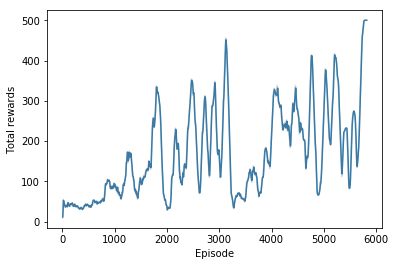

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

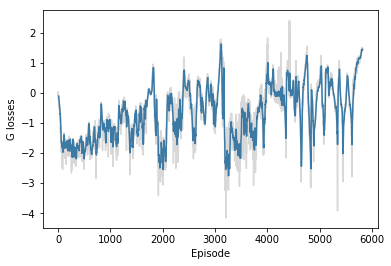

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

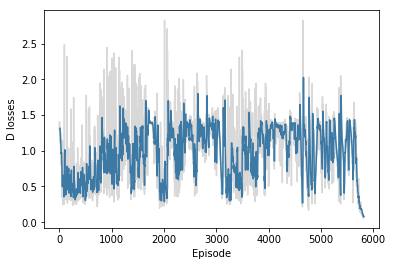

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [28]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model2.ckpt
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.